# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
from itertools import count
import time
import torch
from Agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe", worker_id=1, seed=2)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.29742813 -1.5
 -0.          0.          7.17024279  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
#for i in range(1, 6):                                      # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### 1. Instantiate the Environment and Agent

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=2)

#### 2. Train the Agent with DDPG

In [8]:
def save_model():
    print("Model Save...")
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

In [9]:
def ddpg(n_episodes=3200, max_t=1000, print_every=10, save_every=100):
    scores_deque = deque(maxlen=100)
    scores_global = []
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        
        score_average = 0
        timestep = time.time()
        for t in count():
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states                               # roll over states to next time step
            scores += rewards                                  # update the score (for each agent)            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        score = np.mean(scores)
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        
        if i_episode % save_every == 0:
            save_model()
        
        if i_episode % print_every == 0:
            print('\rEpisode {}, Average Score: {:.2f}, Max: {:.2f}, Min: {:.2f}, Time: {:.2f}'\
                  .format(i_episode, score_average, np.max(scores), np.min(scores), time.time() - timestep), end="\n")        
                    
        if score_average >= 0.5:
            save_model()
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, score_average))            
            break            
            
    return scores_global

scores = ddpg()

Episode 10, Average Score: -0.00, Max: 0.00, Min: -0.01, Time: 0.07
Episode 20, Average Score: -0.00, Max: 0.00, Min: -0.01, Time: 0.07
Episode 30, Average Score: -0.00, Max: 0.00, Min: -0.01, Time: 0.05
Episode 40, Average Score: -0.00, Max: 0.00, Min: -0.01, Time: 0.05
Episode 50, Average Score: -0.00, Max: 0.00, Min: -0.01, Time: 0.05
Episode 60, Average Score: -0.00, Max: 0.00, Min: -0.01, Time: 0.74
Episode 70, Average Score: -0.00, Max: 0.00, Min: -0.01, Time: 0.74
Episode 80, Average Score: -0.00, Max: 0.00, Min: -0.01, Time: 0.74
Episode 90, Average Score: -0.00, Max: 0.00, Min: -0.01, Time: 0.05
Model Save...
Episode 100, Average Score: -0.00, Max: 0.00, Min: -0.01, Time: 0.75
Episode 110, Average Score: -0.00, Max: 0.00, Min: -0.01, Time: 0.73
Episode 120, Average Score: -0.00, Max: 0.00, Min: -0.01, Time: 0.74
Episode 130, Average Score: 0.00, Max: 0.10, Min: -0.01, Time: 1.54
Episode 140, Average Score: 0.00, Max: 0.00, Min: -0.01, Time: 0.05
Episode 150, Average Score: 0.0

Episode 1190, Average Score: 0.02, Max: 0.09, Min: 0.00, Time: 0.79
Model Save...
Episode 1200, Average Score: 0.02, Max: 0.19, Min: 0.10, Time: 2.31
Episode 1210, Average Score: 0.02, Max: 0.00, Min: -0.01, Time: 0.79
Episode 1220, Average Score: 0.03, Max: 0.10, Min: -0.01, Time: 1.49
Episode 1230, Average Score: 0.03, Max: 0.20, Min: 0.09, Time: 3.13
Episode 1240, Average Score: 0.04, Max: 0.10, Min: 0.09, Time: 2.25
Episode 1250, Average Score: 0.05, Max: 0.09, Min: 0.00, Time: 0.78
Episode 1260, Average Score: 0.05, Max: 0.09, Min: 0.00, Time: 0.80
Episode 1270, Average Score: 0.05, Max: 0.10, Min: -0.01, Time: 0.82
Episode 1280, Average Score: 0.05, Max: 0.10, Min: -0.01, Time: 0.79
Episode 1290, Average Score: 0.06, Max: 0.09, Min: 0.00, Time: 0.80
Model Save...
Episode 1300, Average Score: 0.06, Max: 0.10, Min: -0.01, Time: 1.51
Episode 1310, Average Score: 0.06, Max: 0.09, Min: 0.00, Time: 1.51
Episode 1320, Average Score: 0.06, Max: 0.09, Min: 0.00, Time: 0.81
Episode 1330, A

#### 3. Plot¶

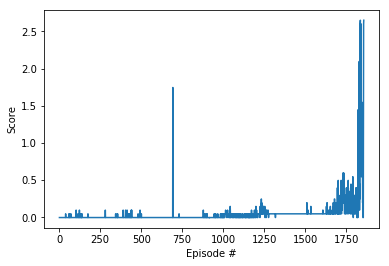

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### 4. Watch a Smart Agent!¶

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))